In [1]:
%matplotlib inline
from IPython.display import HTML
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at `mosthosts_desy.py` and the docstring on `MostHostsDesi` for documentation on how it works.

In [2]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Don't save any passwords to a github archive!
# Release can be one of : daily , everest , fuji , guadalupe , fujilupe
#  (fujilupe is the union of fuji and guadalupe — and currently is broken!)
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
subset = "daily"
mhd = MostHostsDesi( release=subset, force_regen=True, dbuserpwfile="/global/homes/r/raknop/secrets/decatdb_desi_desi" )

[2022-12-12 10:11:57,434 - INFO] - Loading mosthosts table...
[2022-12-12 10:11:58,446 - INFO] - ...mosthosts table loaded.
[2022-12-12 10:11:58,449 - INFO] - Rebuilding info for release daily
[2022-12-12 10:11:58,461 - INFO] - Sending q3c_join query for release daily
[2022-12-12 10:11:58,660 - INFO] - ...temporary table has 7572 rows, 7572 including a desi observation.
[2022-12-12 10:11:58,660 - INFO] - Getting night/redshift/type info
[2022-12-12 10:11:58,994 - INFO] - ...done getting night/redshift/type info, got 8830 rows.
[2022-12-12 10:11:59,652 - INFO] - 6874 of 8830 redshifts left after keeping only latest night
[2022-12-12 10:11:59,653 - INFO] - Building hazdf...
[2022-12-12 10:11:59,711 - INFO] - Building df...
[2022-12-12 10:12:09,239 - INFO] - Done generating dataframes.
[2022-12-12 10:12:09,627 - INFO] - mosthosts_desi_daily.csv and mosthosts_desi_daily_desiobs.csv written.


In [3]:
# Print out some statistics
print( f'...as of when the csv and pkl files were last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("snname"))} different SNe/AGN in MostHosts database' )
print( f'{mhd.df["z"].notnull().sum()} hosts have at least one DESI zwarn=0 redshift' )
print( f'{len( mhd.df[ mhd.df["z"].notnull() ].groupby( "snname" ) )} SNe/AGN have at least one host observed by DESI' )
# I put this here as a self-consistency check between my two dataframes
print( f'The same number again: {len( mhd.haszdf[ mhd.haszdf["zwarn"]==0 ].reset_index().groupby( "snname" ) )}' )

# Make a dataframe that's like df, but that omits all QSOs and that all have at least one redshift
print( '' )
justsne = mhd.haszdf[ mhd.haszdf['zwarn']==0 ]
justsne = justsne[ justsne['program'].apply( lambda x: 'QSO' not in x ) ]
print( f'{len( justsne.reset_index().groupby( ["snname", "index"] ))} non-QSO MostHosts have at least one DESI observation' )
print( f'{len( justsne.reset_index().groupby( "snname" ))} SNe (i.e. non-QSO targets) have at least one host observed by DESI' )


...as of when the csv and pkl files were last regenerated:
20174 entries in the MostHosts database
14958 different SNe/AGN in MostHosts database
5535 hosts have at least one DESI zwarn=0 redshift
5301 SNe/AGN have at least one host observed by DESI
The same number again: 5301

4524 non-QSO MostHosts have at least one DESI observation
4290 SNe (i.e. non-QSO targets) have at least one host observed by DESI


In [4]:
# If you want to figure out which supernovae have multiple hosts, you can poke at the mhd.df dataframe similar to the following

origtablehostcount = mhd.df.reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(origtablehostcount == i).sum()} candidates in the mosthosts table have {i} hosts' )
# print( f'The candidates with 3 observed hosts are: {origtablehostcount[origtablehostcount == 5].index.values}' )

print( '' )

obshostcount = mhd.df[ mhd.df['z'].notnull() ].reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(obshostcount == i).sum()} candidates have {i} hosts observed by DESI with zwarn=0' )

11240 candidates in the mosthosts table have 1 hosts
2367 candidates in the mosthosts table have 2 hosts
1217 candidates in the mosthosts table have 3 hosts
123 candidates in the mosthosts table have 4 hosts
10 candidates in the mosthosts table have 5 hosts
0 candidates in the mosthosts table have 6 hosts
1 candidates in the mosthosts table have 7 hosts

5086 candidates have 1 hosts observed by DESI with zwarn=0
197 candidates have 2 hosts observed by DESI with zwarn=0
17 candidates have 3 hosts observed by DESI with zwarn=0
1 candidates have 4 hosts observed by DESI with zwarn=0
0 candidates have 5 hosts observed by DESI with zwarn=0
0 candidates have 6 hosts observed by DESI with zwarn=0
0 candidates have 7 hosts observed by DESI with zwarn=0


***

## Pulling out information about a specific host from MostHosts

Suppose you want to find out the summary information (i.e. the `df` entry) and all the observations (the `haszdf` entry) for supernova ZTF18acueixn, host 2:

In [5]:
# Once again, I wish I could figure out how to do this cleanly in Pandas
# without resetting the index, and then setting the index back hardcodedly
# to what it was in the first place.

sntoshow = 'ZTF18acueixn'
dextoshow = 2

_tmp = mhd.df.reset_index()
subdf = _tmp.loc[ ( _tmp['spname'] == sntoshow ) & ( _tmp['index'] == dextoshow ) ].set_index( ['snname', 'index'] )
display( HTML( f'<h3>rows of mhd.df for spname={sntoshow} host {dextoshow}</h3>' ) )
display( subdf )

_tmp = mhd.haszdf.reset_index()
display( HTML( f'<br><hr><br><h3>rows of mhd.haszdf for spname={sntoshow} host {dextoshow}</h3>' ) )
subdf = _tmp.loc[ ( _tmp['spname'] == sntoshow ) & ( _tmp['index'] == dextoshow ) ].set_index( ['snname', 'index', 
                                                                                            'targetid', 'petal', 'night' ] )
display( subdf )

#_tmp = mhd.haszdf.reset_index().groupby( ['snname','index'] )['z'].count()
#_tmp[ _tmp > 2 ]

,,ra,dec,pmra,pmdec,ref_epoch,override,hemisphere,sn_ra,sn_dec,sn_z,program,priority,tns_name,iau_name,ptfiptf_name,spname,z,zerr,zdisp
snname,index,,,,,,,,,,,,,,,,,,,
ZTF18acueixn,2,213.86507,-0.444482,0.0,0.0,0.0,False,south,213.869901,-0.442633,-9999.0,SNe_Ia,3.0,None,None,None,ZTF18acueixn,0.139894,0.000024,0.000174


tileid         ra  \
snname       index targetid          petal night                         
ZTF18acueixn 2     39627776235408304 7     20210505     527  213.86507   
                                           20210517     534  213.86507   
                                     5     20210612   20082  213.86507   

                                                          dec  pmra  pmdec  \
snname       index targetid          petal night                             
ZTF18acueixn 2     39627776235408304 7     20210505 -0.444482   0.0    0.0   
                                           20210517 -0.444482   0.0    0.0   
                                     5     20210612 -0.444482   0.0    0.0   

                                                     ref_epoch  override  \
snname       index targetid          petal night                           
ZTF18acueixn 2     39627776235408304 7     20210505        0.0     False   
                                           20210517        0.0     False   
                                     5     20210612        0.0     False   

                                                    hemisphere       sn_ra  \
snname       index targetid          petal night                             
ZTF18acueixn 2     39627776235408304 7     20210505      south  213.869901   
                                           20210517      south  213.869901   
                                     5     20210612      south  213.869901   

                                                       sn_dec  ...  iau_name  \
snname       index targetid          petal night               ...             
ZTF18acueixn 2     39627776235408304 7     20210505 -0.442633  ...      None   
                                           20210517 -0.442633  ...      None   
                                     5     20210612 -0.442633  ...      None   

                                                    ptfiptf_name  \
snname       index targetid          petal night                   
ZTF18acueixn 2     39627776235408304 7     20210505         None   
                                           20210517         None   
                                     5     20210612         None   

                                                           spname         z  \
snname       index targetid          petal night                              
ZTF18acueixn 2     39627776235408304 7     20210505  ZTF18acueixn  0.139943   
                                           20210517  ZTF18acueixn  0.139901   
                                     5     20210612  ZTF18acueixn  0.139770   

                                                         zerr zwarn  \
snname       index targetid          petal night                      
ZTF18acueixn 2     39627776235408304 7     20210505  0.000041     0   
                                           20210517  0.000034     0   
                                     5     20210612  0.000059     0   

                                                            chi2    deltachi2  \
snname       index targetid          petal night                                
ZTF18acueixn 2     39627776235408304 7     20210505  9015.075945  1128.299966   
                                           20210517  9578.805407  1282.806524   
                                     5     20210612  8381.434251  1359.566877   

                                                     spectype  subtype  
snname       index targetid          petal night                        
ZTF18acueixn 2     39627776235408304 7     20210505    GALAXY           
                                           20210517    GALAXY           
                                     5     20210612    GALAXY           

[3 rows x 24 columns]

***

## Finding DESI targets from the main survey that are mosthosts

Call the `find_main_targets` method of your MostHostsDesi object to load up the property `maintargets` with a data frame that matches targets from the DESI main survey to mosthsots.  By default, it searches for targets within 1" of the position of the MostHosts host.

In [6]:
# Match mosthosts to main desi targets
# Set force_regen=True to actually read the database; otherwise
# it will try to read a pickle file in the current directory
mhd.find_main_targets( force_regen=True )

print( f"{len(mhd.maintargets.groupby( ['snname', 'index'] ).first())} "
       f"of {len(mhd.df)} mosthosts show up in DESI main targets" )

subdf = mhd.maintargets[ mhd.maintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(mhd.df)} mosthosts have a bgs_target > 0" )

_justsneindexes = mhd.df[ ['QSO' not in p for p in mhd.df['program'] ] ].index
_tmptargs = mhd.maintargets.reset_index().set_index( ['snname', 'index'] )
_justsnetargets = _tmptargs.loc[ [i in _justsneindexes for i in _tmptargs.index], :]
print( f"{len(_justsnetargets.groupby( ['snname','index'] ).first())} "
       f"of {len(_justsneindexes)} non-QSO mosthosts show up in DESI main targets" )
subdf = _justsnetargets[ _justsnetargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['snname', 'index'] ).first())} "
       f"of {len(_justsneindexes)} non-QSO mosthosts have a bgs_target > 0" )


[2022-12-12 10:12:28,732 - INFO] - Searching DESI targets for mosthosts
[2022-12-12 10:12:28,733 - DEBUG] - Sending query: b'SELECT m.snname,m.index,m.tns_name,m.iau_name,m.ptfiptf_name,t.survey,t.whenobs,t.targetid,t.desi_target,t.bgs_target,t.mws_target,t.scnd_target FROM static.mosthosts m INNER JOIN general.maintargets t ON q3c_join(m.ra,m.dec,t.ra,t.dec,0.0002777777777777778)'
[2022-12-12 10:12:29,529 - INFO] - Wrote desi target info to mosthosts_desi_maintargets.pkl


12430 of 20174 mosthosts show up in DESI main targets
10586 of 20174 mosthosts have a bgs_target > 0
10690 of 18173 non-QSO mosthosts show up in DESI main targets
10387 of 18173 non-QSO mosthosts have a bgs_target > 0


In [7]:
# Suppose we want to find if there are mosthosts associated with a given targetid:

# targid = 39633472859408454   # THis is one that, at least as of this writing, had no observations yet
targid = 39632956133737923     # This one has multiple targetIDs that match the same mosthosts entry, and multiple observations

mytargmh = mhd.maintargets.xs( targid, level='targetid' )
# (This will throw a KeyError exception if targid isn't found in mhd.maintargets.)

display( HTML(f"<h3>Mosthosts for target {targid}:") )
display( mytargmh )

# If we want to see if they have any redshifts:

_dexes = list( set( mytargmh.reset_index().set_index( ['snname', 'index'] ).index ) )

display( HTML(f"<h3>Summary redshift info (if any) for mosthosts that overlap {targid}:") )
display( mhd.df.loc[ _dexes, [ 'spname','sn_z','z','zerr','zdisp' ] ] )

#...there must be a better way to do pandas subsetting than all
# this reset_index() followed by a set_index() to what the index
# was in the first place.

display( HTML(f"<h3>Full redshift info (if any) for target {targid}:") )
_tmpdf = mhd.haszdf.reset_index().set_index( ['snname','index'] )
_dexes = [ d for d in _dexes if d in mhd.haszdf.index ]
display( _tmpdf.loc[ _dexes ].reset_index().set_index( ['snname', 'index', 'targetid', 'tileid', 'petal', 'night'] ) )


tns_name iau_name ptfiptf_name  \
snname       index survey whenobs                                    
ZTF18aahjdnz 1     main   dark     AT2018lvi     None         None   
                          bright   AT2018lvi     None         None   

                                           desi_target  bgs_target  \
snname       index survey whenobs                                    
ZTF18aahjdnz 1     main   dark     8070450532247929860        1028   
                          bright   8070450532247929860        1028   

                                   mws_target  scnd_target     spname  
snname       index survey whenobs                                      
ZTF18aahjdnz 1     main   dark            768    100663296  AT2018lvi  
                          bright          768    100663296  AT2018lvi

,,spname,sn_z,z,zerr,zdisp
snname,index,,,,,
ZTF18aahjdnz,1,AT2018lvi,0.12,0.11995,0.000004,0.00003


ra  \
snname       index targetid            tileid petal night                  
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  199.598992   
                   2305843020185996587 42508  5     20220612  199.598992   

                                                                    dec  pmra  \
snname       index targetid            tileid petal night                       
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  33.793802   0.0   
                   2305843020185996587 42508  5     20220612  33.793802   0.0   

                                                              pmdec  \
snname       index targetid            tileid petal night             
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515    0.0   
                   2305843020185996587 42508  5     20220612    0.0   

                                                              ref_epoch  \
snname       index targetid            tileid petal night                 
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515        0.0   
                   2305843020185996587 42508  5     20220612        0.0   

                                                              override  \
snname       index targetid            tileid petal night                
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515     False   
                   2305843020185996587 42508  5     20220612     False   

                                                             hemisphere  \
snname       index targetid            tileid petal night                 
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515      north   
                   2305843020185996587 42508  5     20220612      north   

                                                                  sn_ra  \
snname       index targetid            tileid petal night                 
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  199.59913   
                   2305843020185996587 42508  5     20220612  199.59913   

                                                                sn_dec  sn_z  \
snname       index targetid            tileid petal night                      
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  33.79373  0.12   
                   2305843020185996587 42508  5     20220612  33.79373  0.12   

                                                              ... iau_name  \
snname       index targetid            tileid petal night     ...            
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  ...     None   
                   2305843020185996587 42508  5     20220612  ...     None   

                                                              ptfiptf_name  \
snname       index targetid            tileid petal night                    
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515          None   
                   2305843020185996587 42508  5     20220612          None   

                                                                 spname  \
snname       index targetid            tileid petal night                 
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  AT2018lvi   
                   2305843020185996587 42508  5     20220612  AT2018lvi   

                                                                     z  \
snname       index targetid            tileid petal night                
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  0.119942   
                   2305843020185996587 42508  5     20220612  0.119972   

                                                                  zerr zwarn  \
snname       index targetid            tileid petal night                      
ZTF18aahjdnz 1     39632956133737923   2181   5     20210515  0.000005     0   
                   2305843020185996587 42508  5     20220612  0.000008     0   

                                                                      chi2  \
snname     

***

## Some summary plots

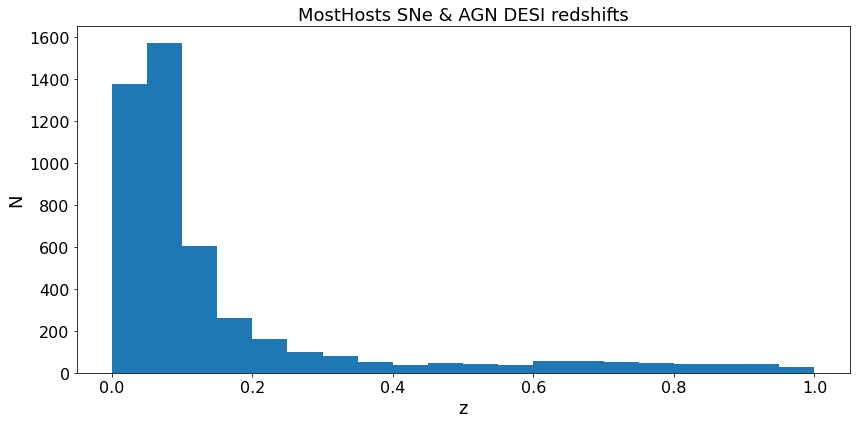

In [8]:
# Make a histogram of independent supernova z and AGN.  The host z might not be the right one, as
#   the plot just naively grabs the first host listed for each SN.

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe & AGN DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( f'mosthostsz_{subset}.svg' )


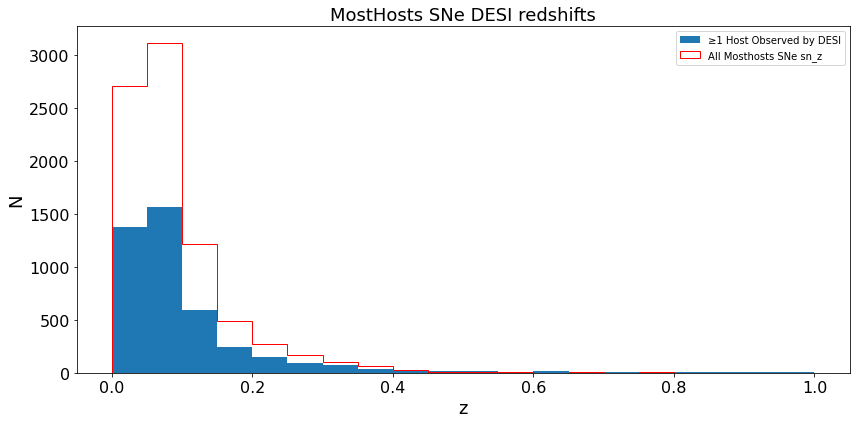

In [9]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = justsne.groupby( 'snname' ).agg('first')

allmhjustsne = mhd.df.groupby( 'snname' ).agg('first')
allmhjustsne = allmhjustsne[ allmhjustsne['program'].apply( lambda x: 'QSO' not in x ) ]

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20, label="≥1 Host Observed by DESI" )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )

ax.hist( allmhjustsne['sn_z'], range=(0, 1), bins=20, histtype='step', color='red', label="All Mosthosts SNe sn_z" )

ax.legend()

fig.show()
fig.savefig( f'mosthosts_justsnez_{subset}.svg' )


/tmp/ipykernel_42560/3901605094.py:9: RuntimeWarning: invalid value encountered in true_divide
  ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )


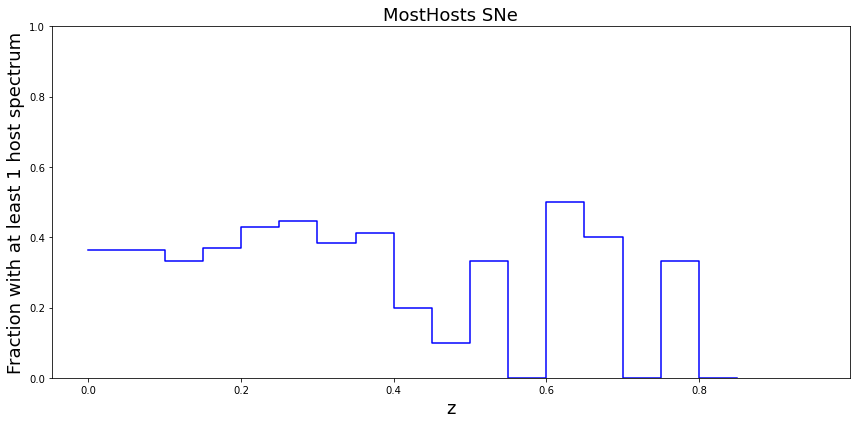

In [10]:
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1)
obshist, obsbins = np.histogram( subframe['sn_z'], range=(0,1), bins=20 )
allhist, allbins = np.histogram( allmhjustsne['sn_z'], range=(0,1), bins=20 )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('Fraction with at least 1 host spectrum', fontsize=18)
ax.set_title( 'MostHosts SNe', fontsize=18 )
ax.set_ylim( 0, 1 )
ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )
fig.show()


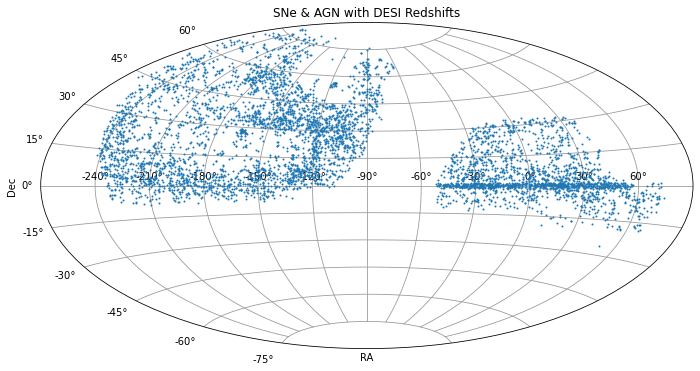

In [11]:
# Plot them on the sky

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')


fig = pyplot.figure( figsize=(12,6) )
ax = fig.add_subplot(1, 1, 1, projection='aitoff' )
# I want to plot the aitoff projection not having 0 at the center
# I don't know if there's a simple argument to give to the axes for
# this, so I'll manually offset my RAs, and then manually edit the
# tick labels, to offset by raoff degrees.
raoff = 90
ras = ( subframe['ra'].values + raoff ) * math.pi/180.
ras[ ras < -math.pi ] = ras[ ras < -math.pi ] + 2*math.pi
ras[ ras >= math.pi ] = ras[ ras >= math.pi ] - 2*math.pi
ax.set_longitude_grid( 30 )
ax.set_latitude_grid( 15 )
ax.grid( which='major', color='#999999' )
ax.plot( ras, subframe['dec'].values*math.pi/180., linestyle='None', marker='o', markersize=1 )
fig.canvas.draw()
labels = [ f'{float(lab.get_text()[:-1])-raoff:.0f}°' for lab in ax.get_xticklabels() ]
ax.set_xticklabels( labels )
# Remove the 75° label so it doesn't overlap the title.
# THere's probably a more elegant way to do this.
labels = [ lab for lab in ax.get_yticklabels()[:-1] ] + ['']
ax.set_yticklabels( labels )
ax.set_xlabel( "RA" )
ax.set_ylabel( "Dec" )
ax.set_title( "SNe & AGN with DESI Redshifts" )
fig.show()
fig.savefig( f'mosthostdesiz_skydist_{subset}.svg' )

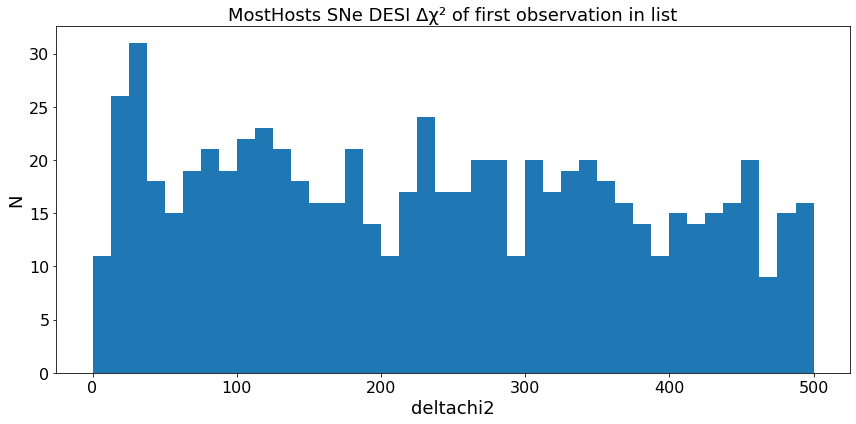

In [12]:
subframe = justsne.groupby( 'snname' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['deltachi2'].values, range=(0,500), bins=40)
ax.set_xlabel('deltachi2', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI Δχ² of first observation in list', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()


## Stuff below is just futzing around with the tables to subset by name, etc.

In [13]:
subframe = justsne.groupby( 'snname' ).agg('first')
dexes = subframe.index.values
ztfobjs = subframe[ [ it[0:3]=='ZTF' for it in dexes ] ]
# I know I could have done a pandas count something something,
# but I might want this subframe later.
print( f"There are {len(ztfobjs)} SNe with DESI-observed hosts whose names start with \"ZTF\"" )

There are 2400 SNe with DESI-observed hosts whose names start with "ZTF"


In [14]:
tmp = mhd.df.reset_index()
dexes = tmp.index.values
tmp[ [ tmp.snname[i][0:3]=='ZTF' for i in dexes ] ].groupby( 'snname' ).agg('first')

,index,ra,dec,pmra,pmdec,ref_epoch,override,hemisphere,sn_ra,sn_dec,sn_z,program,priority,tns_name,iau_name,ptfiptf_name,spname,z,zerr,zdisp
snname,,,,,,,,,,,,,,,,,,,,
ZTF17aaagyfw,1,74.256866,-23.411080,0.0,0.0,0.0,False,south,74.263277,-23.414417,-9999.0000,SNe_Ia,3.0,AT2018ksp,None,None,AT2018ksp,NaN,NaN,NaN
ZTF17aaaikab,1,116.131128,48.443103,0.0,0.0,0.0,False,north,116.130960,48.441800,-9999.0000,RCF,3.0,AT2019bgj,None,None,AT2019bgj,NaN,NaN,NaN
ZTF17aaaiwbs,1,127.811263,6.281893,0.0,0.0,0.0,False,south,127.800900,6.277471,-9999.0000,SNe_Ia,3.0,None,None,None,ZTF17aaaiwbs,0.326757,0.00001,0.0
ZTF17aaajijv,1,156.223097,23.544844,0.0,0.0,0.0,False,south,156.223503,23.542774,-9999.0000,SNe_Ia,3.0,AT2018iqp,None,None,AT2018iqp,NaN,NaN,NaN
ZTF17aaajnki,1,186.453750,33.546860,0.0,0.0,0.0,False,north,186.453590,33.546900,0.0011,RCF/ZTFmarshal,3.0,None,None,None,ZTF17aaajnki,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acmjgyw,1,3.423460,28.917162,0.0,0.0,0.0,False,south,3.426776,28.919156,-9999.0000,ZTFmarshal,1.0,AT2020xuq,None,None,AT2020xuq,NaN,NaN,NaN
ZTFC19ccl,1,268.746115,44.359451,0.0,0.0,0.0,False,north,268.746026,44.358329,0.1400,ZTFmarshal,1.0,None,None,None,ZTFC19ccl,NaN,NaN,NaN
ZTFC19cxt,1,275.615560,51.098301,0.0,0.0,0.0,False,north,275.614240,51.099173,0.1760,ZTFmarshal,1.0,None,None,None,ZTFC19cxt,NaN,NaN,NaN


In [15]:
# Save these ZTF supernovae to a file for my own sinister purposes
ztfobjs[ ['z', 'ra', 'dec' ] ]
with open( "cheesyfujiztflist.txt", "w" ) as ofp:
    for i in range(len(ztfobjs)):
        ofp.write( f"{ztfobjs.reset_index()['snname'][i]} {ztfobjs.reset_index()['ra'][i]} {ztfobjs.reset_index()['dec'][i]}\n" )
        

In [16]:
ztfobjs['program'].unique()

array(['SNe_Ia', 'SNe_Ia/RCF/ZTFmarshal', 'ZTFmarshal', 'SNe_Ia/RCF',
       'SNe_Ia/ZTFmarshal', 'RCF', 'RCF/ZTFmarshal', 'IIps/ZTFmarshal',
       'RCF/IIps/ZTFmarshal', 'SNe_Ia/RCF/IIps/ZTFmarshal',
       'SNe_Ia/IIps/ZTFmarshal', 'SNe_Ia/RCF/Anna', 'one_shot_dL',
       'Anna/ZTFmarshal', 'RCF/RCF/RCF/ZTFmarshal/ZTFmarshal'],
      dtype=object)

In [17]:
# ztfobjs['program'].values is an object, not a string, so this is convolted
ztfsne = ztfobjs[ np.char.find( np.array( ztfobjs['program'].values, dtype=str ), 'SNe_Ia' ) >= 0 ]
print( f'There are {len(ztfsne)} SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"' )

There are 1012 SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"


In [18]:
justptf = justsne[ justsne['ptfiptf_name'] != 'None' ]
print( f'There are {len(justptf)} SNe with a non-"None" ptfiptf_name' )

There are 888 SNe with a non-"None" ptfiptf_name


(-0.01, 0.01)

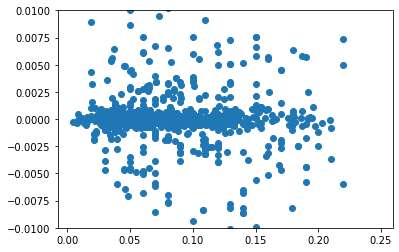

In [19]:
pyplot.plot( justptf['sn_z'], justptf['z']-justptf['sn_z'], linestyle='', marker='o' )
pyplot.ylim( -0.01, 0.01 )

In [20]:

pandas.options.display.max_rows = 500
justptf[ ['ptfiptf_name', 'ra', 'dec', 'z'] ]

ptfiptf_name  \
snname index targetid            tileid petal night                   
09ac   1     39633204071631854   20620  9     20220421      PTF09ac   
09aj   1     39627943986595403   23097  8     20220406      PTF09aj   
09alu  1     39633304558764813   174    4     20210405     PTF09alu   
                                 182    4     20210506     PTF09alu   
09amm  1     39633039919156981   25475  1     20220512     PTF09amm   
...                                                             ...   
15wd   1     39633321822522160   81058  2     20210324     iPTF15wd   
15wk   1     39628243766084410   24481  9     20211021     iPTF15wk   
15xc   1     39632945849304349   21175  0     20210516     iPTF15xc   
15zr   1     39633311340954958   81066  0     20210326     iPTF15zr   
             2305843015475793700 41610  3     20220316     iPTF15zr   

                                                                ra        dec  \
snname index targetid            tileid petal night                             
09ac   1     39633204071631854   20620  9     20220421  186.149690  47.237527   
09aj   1     39627943986595403   23097  8     20220406  146.376831   6.539819   
09alu  1     39633304558764813   174    4     20210405  214.572816  53.788987   
                                 182    4     20210506  214.572816  53.788987   
09amm  1     39633039919156981   25475  1     20220512  230.872538  37.878850   
...                                                            ...        ...   
15wd   1     39633321822522160   81058  2     20210324  174.725250  55.057643   
15wk   1     39628243766084410   24481  9     20211021  128.766206  19.185778   
15xc   1     39632945849304349   21175  0     20210516  186.079167  33.183806   
15zr   1     39633311340954958   81066  0     20210326  179.745833  54.239028   
             2305843015475793700 41610  3     20220316  179.745833  54.239028   

                                                               z  
snname index targetid            tileid petal night               
09ac   1     39633204071631854   20620  9     20220421  0.163469  
09aj   1     39627943986595403   23097  8     20220406  0.086857  
09alu  1     39633304558764813   174    4     20210405  0.074413  
                                 182    4     20210506  0.074455  
09amm  1     39633039919156981   25475  1     20220512  0.066120  
...                                                          ...  
15wd   1     39633321822522160   81058  2     20210324  0.057354  
15wk   1     39628243766084410   24481  9     20211021  0.208930  
15xc   1     39632945849304349   21175  0     20210516  0.021921  
15zr   1     39633311340954958   81066  0     20210326  0.012237  
             2305843015475793700 41610  3     20220316  0.012212  

[888 rows x 4 columns]

In [21]:
# Get a count of how many times each host has zwarn=0 observations
numobs = mhd.haszdf.groupby(level=[0,1]).aggregate('count').rename( {'ra': 'numobs'}, axis=1 )['numobs']

In [22]:
numobs[numobs>3]

snname                      index
09iag                       1        4
10ctd                       1        4
10wxp                       1        4
12dnn                       1        6
13adc                       1        7
2006lj                      1        4
AGN_1005                    1        4
AGN_1025                    1        4
AGN_1068                    1        5
AGN_1070                    1        5
AGN_1133                    1        4
AGN_1155                    1        6
AGN_1163                    1        4
AGN_1235                    1        4
AGN_1242                    1        4
AGN_1280                    1        4
AGN_1317                    1        4
AGN_1351                    1        6
AGN_1433                    1        4
AGN_144                     1        4
AGN_1464                    1        4
AGN_1486                    1        4
AGN_1520                    1        6
AGN_1548                    1        4
AGN_1612                    1 

In [23]:
mhd.haszdf.xs( 'ZTF18aavniyw', level=0 )

ra        dec  pmra  \
index targetid            tileid petal night                                   
1     39633274766623836   20593  6     20220317  172.876147  51.628972   0.0   
                          22162  1     20220218  172.876147  51.628972   0.0   
                          81064  4     20210327  172.876147  51.628972   0.0   
      2305843015459014979 81088  6     20210404  172.876147  51.628972   0.0   

                                                 pmdec  ref_epoch  override  \
index targetid            tileid petal night                                  
1     39633274766623836   20593  6     20220317    0.0        0.0     False   
                          22162  1     20220218    0.0        0.0     False   
                          81064  4     20210327    0.0        0.0     False   
      2305843015459014979 81088  6     20210404    0.0        0.0     False   

                                                hemisphere       sn_ra  \
index targetid            tileid petal night                             
1     39633274766623836   20593  6     20220317      north  172.875062   
                          22162  1     20220218      north  172.875062   
                          81064  4     20210327      north  172.875062   
      2305843015459014979 81088  6     20210404      north  172.875062   

                                                    sn_dec   sn_z  ...  \
index targetid            tileid petal night                       ...   
1     39633274766623836   20593  6     20220317  51.629381  0.055  ...   
                          22162  1     20220218  51.629381  0.055  ...   
                          81064  4     20210327  51.629381  0.055  ...   
      2305843015459014979 81088  6     20210404  51.629381  0.055  ...   

                                                iau_name  ptfiptf_name  \
index targetid            tileid petal night                             
1     39633274766623836   20593  6     20220317     None          None   
                          22162  1     20220218     None          None   
                          81064  4     20210327     None          None   
      2305843015459014979 81088  6     20210404     None          None   

                                                    spname         z  \
index targetid            tileid petal night                           
1     39633274766623836   20593  6     20220317  AT2018ceb  0.055007   
                          22162  1     20220218  AT2018ceb  0.054975   
                          81064  4     20210327  AT2018ceb  0.054987   
      2305843015459014979 81088  6     20210404  AT2018ceb  0.054993   

                                                     zerr zwarn          chi2  \
index targetid            tileid petal night                                    
1     39633274766623836   20593  6     20220317  0.000007     0  19777.946017   
                          22162  1     20220218  0.000008     0  15133.183074   
                          81064  4     20210327  0.000005     0  26394.147615   
      2305843015459014979 81088  6     20210404  0.000034     0   8887.532886   

                                                    deltachi2  spectype  \
index targetid            tileid petal night                              
1     39633274766623836   20593  6     20220317  16177.535978    GALAXY   
                          22162  1     20220218  10326.905492    GALAXY   
                          81064  4     20210327  29484.511359    GALAXY   
      2305843015459014979 81088  6     20210404   1208.371272    GALAXY   

                                                 subtype  
index targetid            tileid petal night              
1     39633274766623836   20593  6     20220317           
                          22162  1     20220218           
                          81064  4     20210327           
      2305843015459014979 81088  6     20210404           

[4 rows x 23 columns]

In [24]:
mhd.haszdf[ mhd.haszdf.spname=='2004hx' ]

ra       dec  \
snname index targetid          tileid petal night                           
2004hx 1     39627761244964607 20675  9     20211219  40.302882 -0.877206   
       2     39627761244964657 26284  8     20221114  40.304096 -0.876849   

                                                      pmra  pmdec  ref_epoch  \
snname index targetid          tileid petal night                              
2004hx 1     39627761244964607 20675  9     20211219   0.0    0.0        0.0   
       2     39627761244964657 26284  8     20221114   0.0    0.0        0.0   

                                                      override hemisphere  \
snname index targetid          tileid petal night                           
2004hx 1     39627761244964607 20675  9     20211219     False      north   
       2     39627761244964657 26284  8     20221114     False      north   

                                                        sn_ra    sn_dec  \
snname index targetid          tileid petal night                         
2004hx 1     39627761244964607 20675  9     20211219  40.3025 -0.879444   
       2     39627761244964657 26284  8     20221114  40.3025 -0.879444   

                                                        sn_z  ... iau_name  \
snname index targetid          tileid petal night             ...            
2004hx 1     39627761244964607 20675  9     20211219  0.0382  ...     None   
       2     39627761244964657 26284  8     20221114  0.0382  ...     None   

                                                      ptfiptf_name  spname  \
snname index targetid          tileid petal night                            
2004hx 1     39627761244964607 20675  9     20211219          None  2004hx   
       2     39627761244964657 26284  8     20221114          None  2004hx   

                                                             z      zerr  \
snname index targetid          tileid petal night                          
2004hx 1     39627761244964607 20675  9     20211219  0.182333  0.000005   
       2     39627761244964657 26284  8     20221114  0.038068  0.000007   

                                                     zwarn         chi2  \
snname index targetid          tileid petal night                         
2004hx 1     39627761244964607 20675  9     20211219     0  9202.791659   
       2     39627761244964657 26284  8     20221114     0  8816.042770   

                                                        deltachi2  spectype  \
snname index targetid          tileid petal night                             
2004hx 1     39627761244964607 20675  9     20211219  6316.372048    GALAXY   
       2     39627761244964657 26284  8     20221114   896.261614    GALAXY   

                                                      subtype  
snname index targetid          tileid petal night              
2004hx 1     39627761244964607 20675  9     20211219           
       2     39627761244964657 26284  8     20221114           

[2 rows x 23 columns]

In [25]:
mhd.df[ mhd.df.spname=="2004hx" ]

ra       dec  pmra  pmdec  ref_epoch  override  \
snname index                                                          
2004hx 1      40.302882 -0.877206   0.0    0.0        0.0     False   
       2      40.304096 -0.876849   0.0    0.0        0.0     False   

             hemisphere    sn_ra    sn_dec    sn_z  program  priority  \
snname index                                                            
2004hx 1          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   
       2          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   

             tns_name iau_name ptfiptf_name  spname         z      zerr  zdisp  
snname index                                                                    
2004hx 1         None     None         None  2004hx  0.182333  0.000005    0.0  
       2         None     None         None  2004hx  0.038068  0.000007    0.0